In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import sklearn
import matplotlib
import scipy
import csv
import harmony
import palantir
import pickle
from scipy import sparse
import matplotlib.pyplot as plt
%matplotlib  inline

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


# Read in adata and subset to mesophyll cells. 

In [2]:
total_adata = sc.read(r'C:\Users\amonell\Downloads\AvrRpt2_alone.h5ad')

In [3]:
total_adata = total_adata[total_adata.obs['SCT_snn_res.1'].isin(['7'])]
total_adata.obs_names_make_unique()
sc.pp.highly_variable_genes(total_adata)

In [3]:

total_adata = total_adata[total_adata.obs['SCT_snn_res.1'].isin(['0', '4', '8', '6', '11', '9'])]
total_adata.obs_names_make_unique()
sc.pp.highly_variable_genes(total_adata)

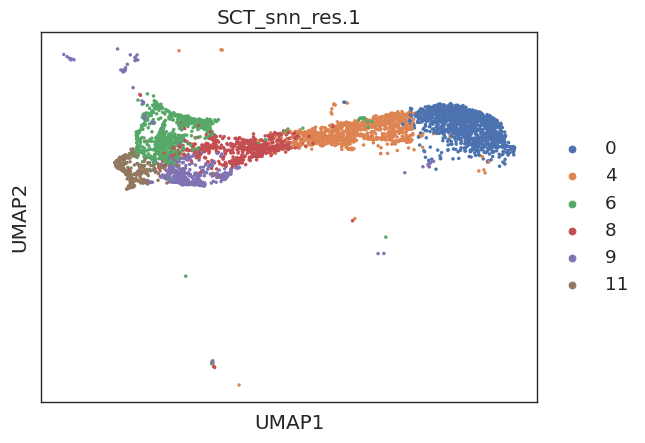

In [60]:
sc.pl.umap(total_adata, color = 'SCT_snn_res.1')

# Define outfolder and run palantir preprocessing on mesophyll cells

In [5]:
outfolder = r'D:\Alex\pseudotime\test'

In [4]:
pca_projections, _ = palantir.utils.run_pca(total_adata, use_hvg=False, n_components=10)

In [6]:
import os
os.mkdir(outfolder)
filehandler = open(os.path.join(outfolder, 'pca_projections_subset.pkl'), 'wb') 
pickle.dump(pca_projections, filehandler)
filehandler.close()

In [7]:

dm_res = palantir.utils.run_diffusion_maps(pca_projections, n_components=5)
ms_data = palantir.utils.determine_multiscale_space(dm_res)
ms_data

Determing nearest neighbor graph...


,0,1
index,,
00_Mock_AAACCGAAGCTAATTG-1,1.536608,-0.452068
00_Mock_AAACCGGCATGAAATG-1,0.862212,0.683754
00_Mock_AAACCGGCATGCAACC-1,0.317426,0.763679
00_Mock_AAACGTACAATCCCTT-1,1.396235,0.937626
00_Mock_AAAGCAAGTCAAGTAT-1,-0.345153,0.693862
...,...,...
AvrRpt2_24h_TTTGGTAAGGCCTAAT-1,-1.246860,-0.233960
AvrRpt2_24h_TTTGTCTAGCCTAACG-1,-2.270334,0.089088
AvrRpt2_24h_TTTGTGTTCATTCATC-1,-2.055496,-0.016437


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:32<00:00,  5.42it/s]


BarnesHut Approximation  took  22.25  seconds
Repulsion forces  took  65.40  seconds
Gravitational forces  took  0.34  seconds
Attraction forces  took  1.20  seconds
AdjustSpeedAndApplyForces step  took  1.51  seconds


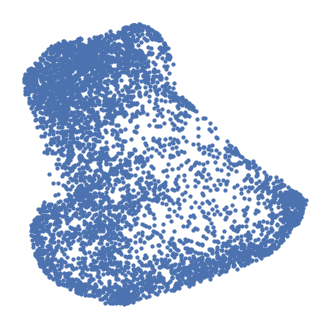

In [39]:
fdl = harmony.plot.force_directed_layout(dm_res['kernel'], total_adata.obs_names)
fig, ax = palantir.plot.plot_tsne(fdl)

In [43]:
total_adata.obsm['X_fdl'] = np.array(fdl)

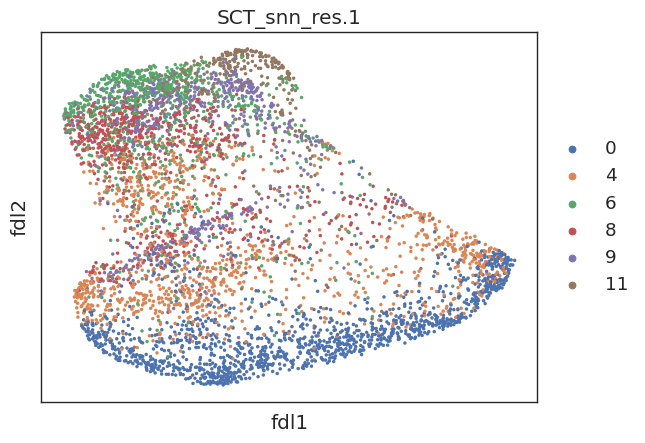

In [45]:
sc.pl.embedding(total_adata, basis = 'fdl', color = 'SCT_snn_res.1')

In [46]:
#arlotta_palantir.X = sparse.csr_matrix(arlotta_palantir.X)
imp_df = palantir.utils.run_magic_imputation(total_adata, dm_res)

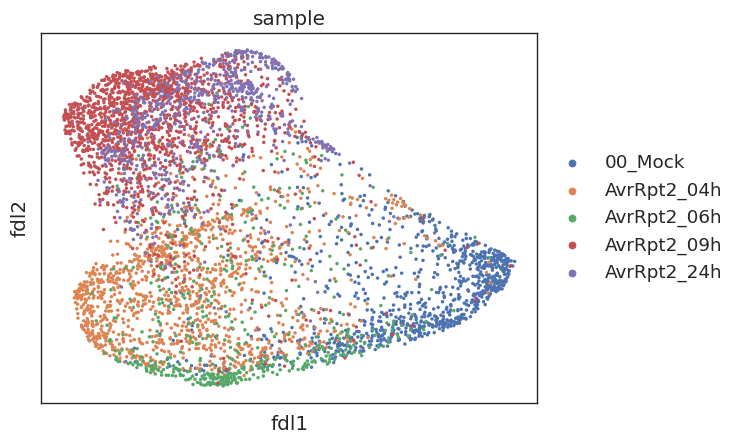

In [47]:
sc.pl.embedding(total_adata, basis = 'fdl', color = 'sample')

In [62]:
sub_mock = total_adata[total_adata.obs['sample'] == '00_Mock', :]

# Find the ID of a control cell that can serve as a starting point based on its position in the UMAP. Set it as the starting cell

In [63]:
sub_mock.obs.iloc[np.where(sub_mock.obsm['X_umap'].T[0] == np.max(sub_mock.obsm['X_umap'].T[0]))].index.tolist()[0]

'00_Mock_CTAATGTCACAGAAAC-1'

In [64]:
st_cell = '00_Mock_CTAATGTCACAGAAAC-1'
#for epidermis starting cell = '00_Mock_CAAAGTGAGGCTACTG-1'

starting_cell_category = []
for i in total_adata.obs.index:
    if i == st_cell:
        starting_cell_category.append(True)
    else:
        starting_cell_category.append(False)

In [65]:
total_adata.obs['starting_cell'] = pd.Categorical(starting_cell_category)

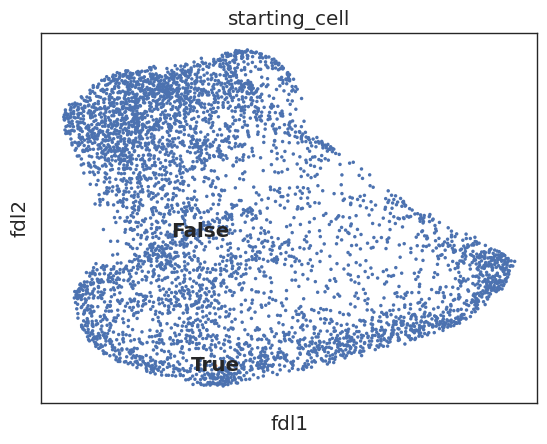

In [66]:
sc.pl.embedding(total_adata, basis = 'fdl', color='starting_cell', legend_loc='on data')

In [67]:
start_cell = [st_cell]

# Go through the different possible terminal state clusters and find cells lying on the extreme periphery of these clusters. Set them as terminal states

In [76]:
cl = '6'
sub_mock = total_adata[total_adata.obs['SCT_snn_res.1'] == cl, :]

sub_mock[sub_mock.obs['SCT_snn_res.1']==cl].obs.iloc[np.where(sub_mock[sub_mock.obs['SCT_snn_res.1']==cl].obsm['X_umap'].T[0] == np.min(sub_mock[sub_mock.obs['SCT_snn_res.1']==cl].obsm['X_umap'].T[0]))].index.tolist()[0]

'AvrRpt2_09h_ATCCGTGAGACACTTA-1'

In [77]:
#terminal states for epidermis - cluster 14 'AvrRpt2_24h_TTGCTCTCAATTGAGA-1'
terminal_states = pd.Series(['Cluster 11', 'Cluster 6'], 
                           index=['AvrRpt2_24h_TCAGGTCCAACCCTAA-1', 'AvrRpt2_09h_ATCCGTGAGACACTTA-1'])

# Run Palantir

In [78]:
pr_res = palantir.core.run_palantir(ms_data, start_cell, knn=20, num_waypoints=100, terminal_states=terminal_states.index, n_jobs=20)

Sampling and flocking waypoints...
Time for determining waypoints: 0.0011166652043660481 minutes
Determining pseudotime...
Shortest path distances using 20-nearest neighbor graph...
Time for shortest paths: 0.024175564448038738 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9991
Correlation at iteration 2: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


In [79]:
pr_res.branch_probs.columns = terminal_states[pr_res.branch_probs.columns]

In [82]:
df_try = pd.DataFrame(total_adata.obsm['X_umap'], columns = ['x', 'y'])

In [83]:
df_try.index = fdl.index

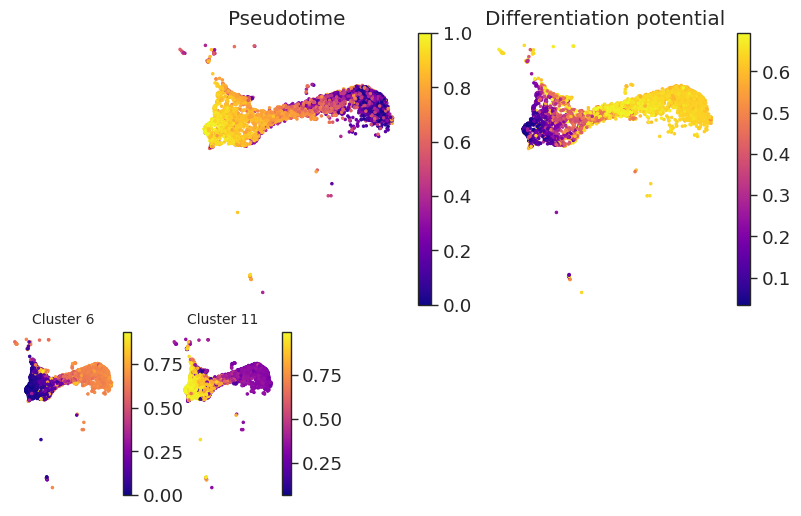

In [85]:
palantir.plot.plot_palantir_results(pr_res, df_try)

# Save Results

In [86]:
import rpy2

In [87]:
import os
os.environ['R_HOME'] = 'C:/Program Files/R/R-4.2.0'

In [88]:

palantir_results = pr_res
filehandler = open(os.path.join(outfolder, 'palantir_results_subset.pkl'), 'wb') 
pickle.dump(palantir_results, filehandler)
filehandler.close()

In [89]:

filehandler = open(os.path.join(outfolder, 'palantir_results_subset.pkl'), 'rb') 
pr_res = pickle.load(filehandler)
filehandler.close()

In [90]:
imp_df.to_hdf(os.path.join(outfolder, 'imp_df_subset.hdf'), key='imp')

In [91]:

filehandler = open(os.path.join(outfolder, 'fdl_subset.pkl'), 'wb') 
pickle.dump(fdl, filehandler)
filehandler.close()

In [23]:
import os
outfolder = r'D:\Alex\pseudotime\ClusterSCT_avronly'
filehandler = open(os.path.join(outfolder, 'palantir_results_subset.pkl'), 'rb') 
pr_res = pickle.load(filehandler)
filehandler.close()
filehandler = open(os.path.join(outfolder, 'pca_projections_subset.pkl'), 'rb') 
pca_projections = pickle.load(filehandler)
filehandler.close()
filehandler = open(os.path.join(outfolder, 'fdl_subset.pkl'), 'rb') 
fdl = pickle.load(filehandler)
filehandler.close()
imp_df = pd.read_hdf(os.path.join(outfolder, 'imp_df_subset.hdf'), 'imp')

In [93]:
total_adata.obs['pseudotime'] = pr_res.pseudotime

In [94]:
total_adata.obs = total_adata.obs.drop(['starting_cell'], axis = 1)

In [95]:
total_adata.write(os.path.join(outfolder, 'pseudotime_scanpy_only_avr.h5ad'))

# Show Pseudotime on Original adata

In [96]:
original_adata = sc.read(r'C:\Users\amonell\Downloads\AvrRpt2_alone.h5ad')

In [97]:
original_adata.obs = original_adata.obs.merge(total_adata.obs, how='outer')

c:\Users\amonell\Anaconda3\envs\palantir\lib\site-packages\anndata\_core\anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


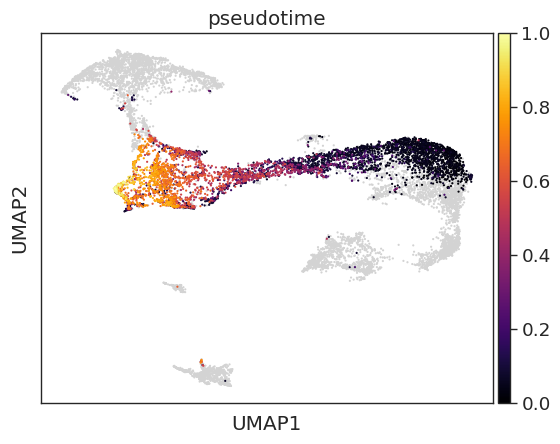

In [100]:
sc.pl.umap(original_adata, color = 'pseudotime', cmap = 'inferno')

# Calculate Gene Trends Across Pseudotime

In [101]:
gene_subset = pd.read_csv(r'C:\Users\amonell\PlantMERFISH\DataPathogenPanel1\geneID_to_geneName_MERSCOPE_panel1.txt', header=0, index_col=0, sep = '\t')

In [102]:
genes = gene_subset['gene_name'].tolist()

In [2]:
for ge in range(len(genes)):
    gene_trends = palantir.presults.compute_gene_trends(pr_res, imp_df.loc[:, [genes[ge]]])
    palantir.plot.plot_gene_trends(gene_trends, output_folder=outfolder)


In [14]:
%matplotlib inline

In [13]:
gene_trends = palantir.presults.compute_gene_trends(pr_res, imp_df)

Cluster 11
Time for processing Cluster 11: 31.277384189764657 minutes


# Creating heatmaps of gene trends across pseudotime

In [2]:
import os

In [3]:
outfolder = r'D:/Alex/pseudotime/ClusterSCT_avronly'

In [4]:
filehandler = open(os.path.join(outfolder, r'D:\Alex\MERSCOPE_reanalysis_output\final_figures_avr_only\gene_trends\trends_all.pkl'), 'rb') 
gene_trends = pickle.load(filehandler)
filehandler.close()


In [12]:
from sklearn.preprocessing import StandardScaler

In [13]:
mat = gene_trends['Cluster 11']["trends"]
mat = pd.DataFrame(
    StandardScaler().fit_transform(mat.T).T,
    index=mat.index,
    columns=mat.columns,
)

arr_hold = []
indexes = []
for index, row in mat.iterrows():
    try:
        arr_hold.append(int(np.mean(np.where(row > np.percentile(row, 90))[0])))
    except:
        arr_hold.append(1000000)
    indexes.append(index)
df = pd.DataFrame(zip(indexes, arr_hold)).sort_values(1)
df = df[df[1] != 1000000]


c:\Users\amonell\Anaconda3\envs\palantir\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\Users\amonell\Anaconda3\envs\palantir\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [22]:
mat.T[df[0].tolist()].T.to_csv(r'D:\Alex\MERSCOPE_reanalysis_output\final_figures_avr_only\gene_trends\all_rna_final_trends.csv')

<IPython.core.display.Javascript object>


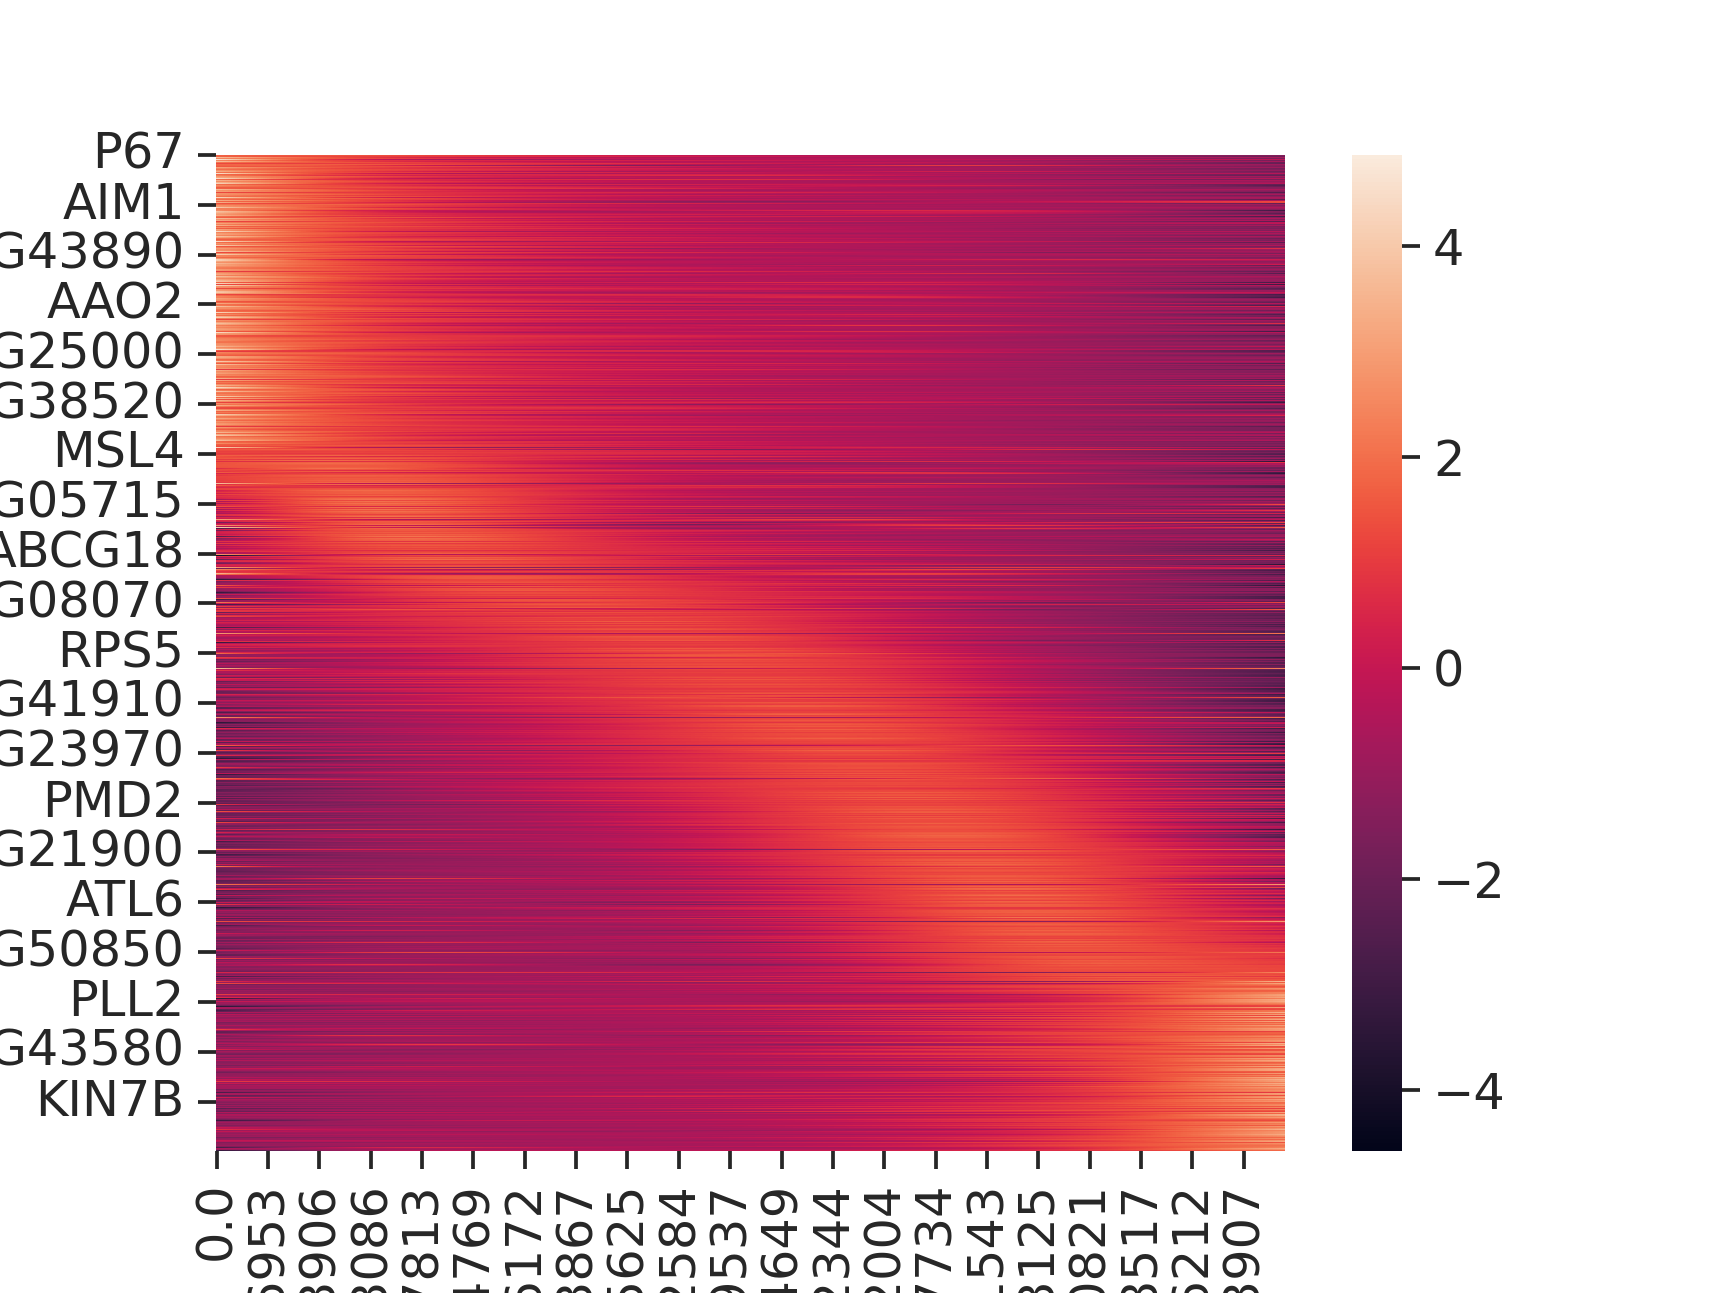

<AxesSubplot:ylabel='index'>

In [21]:
import seaborn as sns
sns.heatmap(mat.T[df[0].tolist()].T)

In [11]:
genelists, mat = palantir.plot.plot_gene_trend_heatmaps(gene_trends)

In [8]:
pd.DataFrame(genelists, columns = ['gene']).to_csv(r'D:\Alex\MERSCOPE_reanalysis_output\final_figures_avr_only\gene_trends\multiome_order.csv')

In [23]:
find_genes = sc.read(r'D:\Alex\MERSCOPE_reanalysis_output\6hr_avr\cellxgene_no_motif6hr_avr.h5ad')
merfish_genes = find_genes.var.index.tolist()
gene_trends = palantir.presults.compute_gene_trends(pr_res, imp_df[merfish_genes])

Cluster 11
Time for processing Cluster 11: 0.642643682161967 minutes


<IPython.core.display.Javascript object>


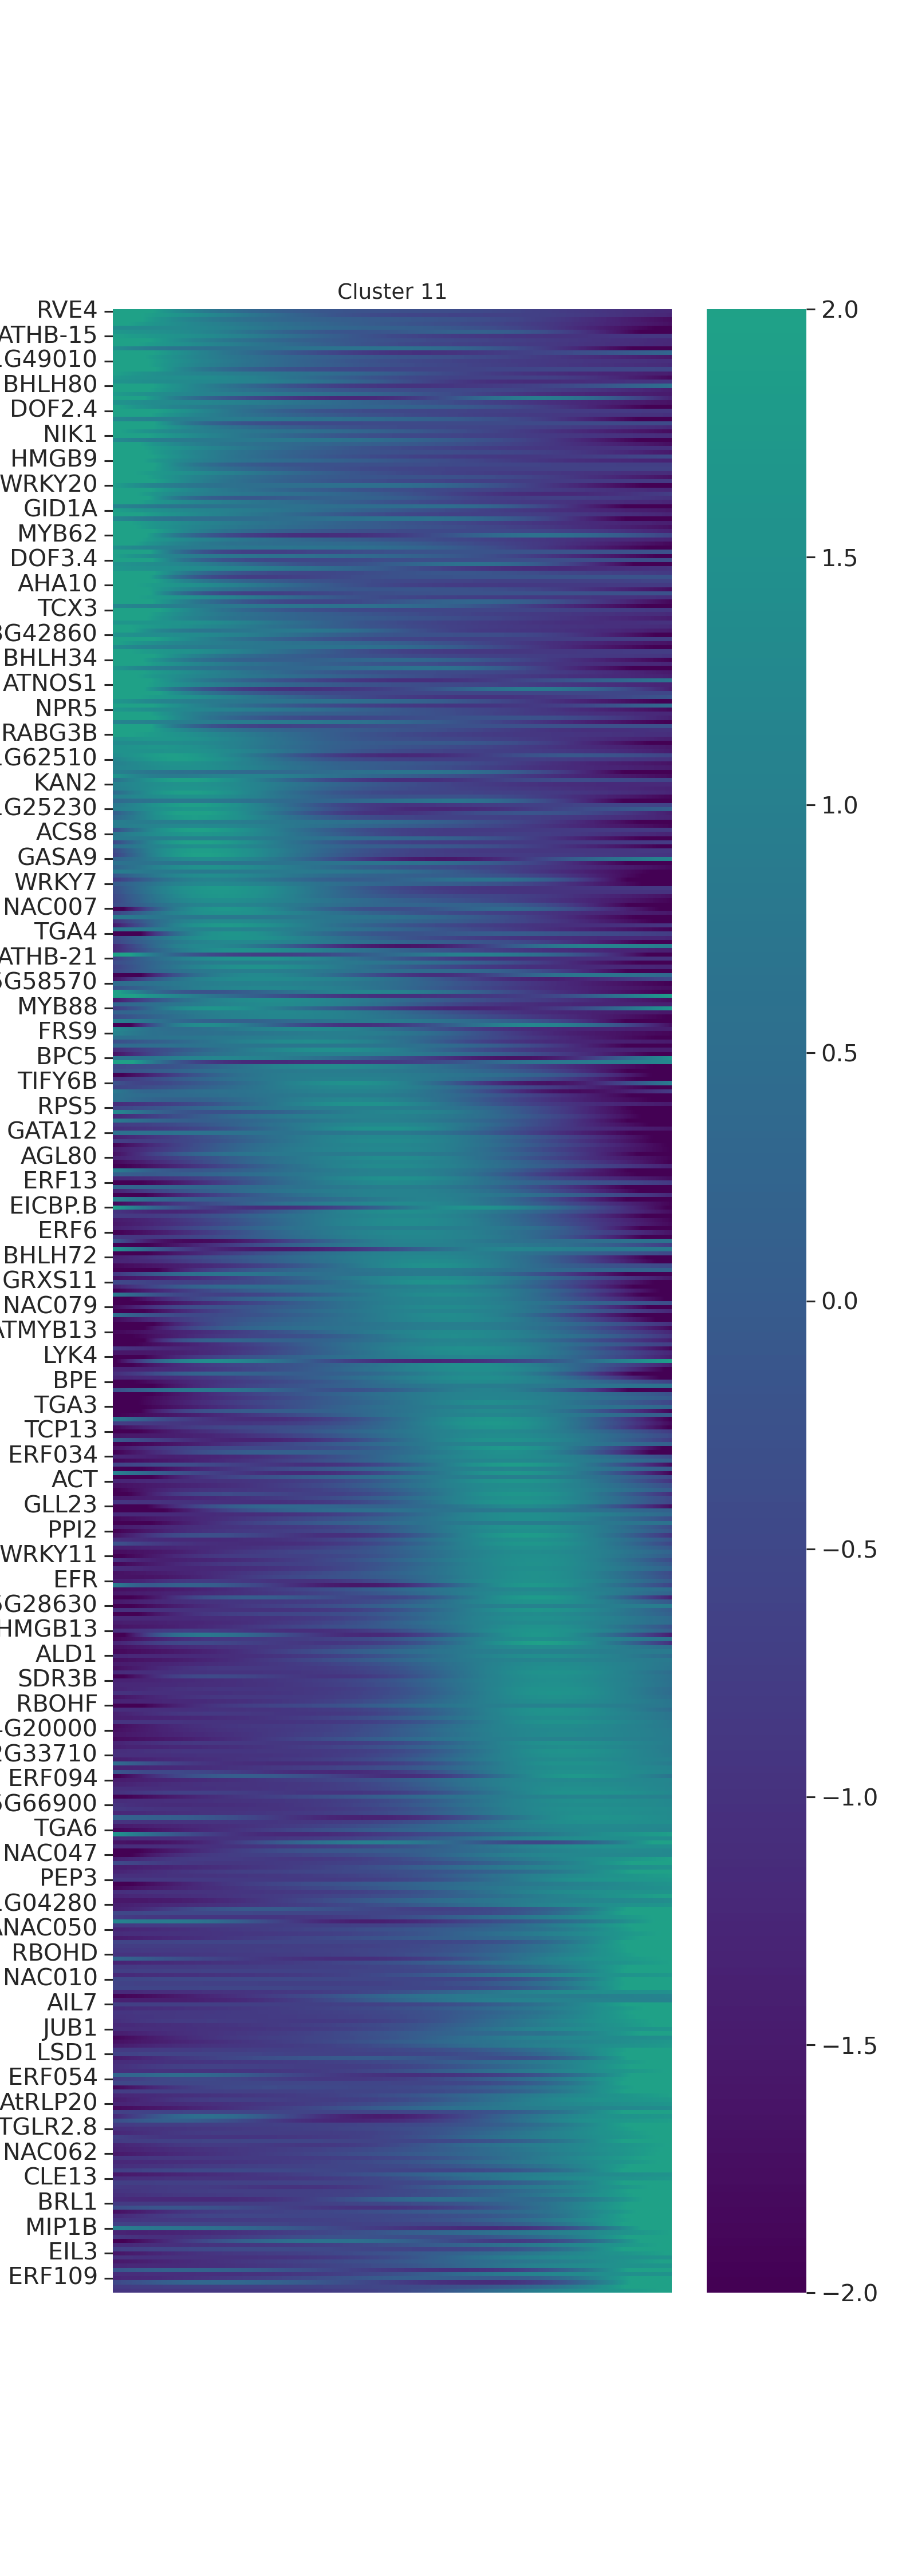

c:\Users\amonell\Anaconda3\envs\palantir\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\Users\amonell\Anaconda3\envs\palantir\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [24]:
genelists = palantir.plot.plot_gene_trend_heatmaps(gene_trends)